# Tatoeba: N-Gram Hashing

Author: Pierre Nugues

In this notbook, we will reduce the size of the n-gram vectors using hashing techniques

This is a preliminary step to understand language detection and CLD3, https://github.com/google/cld3

In [1]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import torch

In [2]:
random.seed(4321)
torch.manual_seed(4321)

## Reading the Dataset

In [3]:
FILE = 'train.tsv'

In [4]:
SMALL_DATASET_PATH = 'small_dataset'
LARGE_DATASET_PATH = 'large_dataset'

In [5]:
SMALL = False

In [6]:
if SMALL:
    dataset_path = SMALL_DATASET_PATH
else:
    dataset_path = LARGE_DATASET_PATH
    
WORKING_FILE = dataset_path + '/' + FILE

We create a generator

In [7]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [8]:
line_generator = file_reader(WORKING_FILE)

And we count the sentences per language

In [9]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [10]:
lang_freqs.most_common(15)

[('rus', 12314),
 ('mkd', 12149),
 ('lfn', 12132),
 ('srp', 12127),
 ('lit', 12126),
 ('lat', 12115),
 ('bul', 12111),
 ('ukr', 12093),
 ('ell', 12084),
 ('vie', 12079),
 ('nld', 12074),
 ('hau', 12073),
 ('kab', 12066),
 ('ron', 12065),
 ('deu', 12064)]

In [11]:
langs = sorted(list(set(lang_freqs.keys())))
langs[:10]

['ara', 'ber', 'bul', 'ces', 'cmn', 'dan', 'deu', 'ell', 'eng', 'epo']

We create an index of the languages

In [12]:
idx2lang = {idx:lang for idx, lang in enumerate(langs)}
idx2lang

{0: 'ara',
 1: 'ber',
 2: 'bul',
 3: 'ces',
 4: 'cmn',
 5: 'dan',
 6: 'deu',
 7: 'ell',
 8: 'eng',
 9: 'epo',
 10: 'fin',
 11: 'fra',
 12: 'hau',
 13: 'heb',
 14: 'hun',
 15: 'ina',
 16: 'ita',
 17: 'jpn',
 18: 'kab',
 19: 'lat',
 20: 'lfn',
 21: 'lit',
 22: 'mar',
 23: 'mkd',
 24: 'nld',
 25: 'pes',
 26: 'pol',
 27: 'por',
 28: 'ron',
 29: 'rus',
 30: 'spa',
 31: 'srp',
 32: 'swc',
 33: 'swe',
 34: 'tlh',
 35: 'tok',
 36: 'tur',
 37: 'ukr',
 38: 'vie'}

In [13]:
lang2idx = {lang:idx for idx, lang in idx2lang.items()}
lang2idx

{'ara': 0,
 'ber': 1,
 'bul': 2,
 'ces': 3,
 'cmn': 4,
 'dan': 5,
 'deu': 6,
 'ell': 7,
 'eng': 8,
 'epo': 9,
 'fin': 10,
 'fra': 11,
 'hau': 12,
 'heb': 13,
 'hun': 14,
 'ina': 15,
 'ita': 16,
 'jpn': 17,
 'kab': 18,
 'lat': 19,
 'lfn': 20,
 'lit': 21,
 'mar': 22,
 'mkd': 23,
 'nld': 24,
 'pes': 25,
 'pol': 26,
 'por': 27,
 'ron': 28,
 'rus': 29,
 'spa': 30,
 'srp': 31,
 'swc': 32,
 'swe': 33,
 'tlh': 34,
 'tok': 35,
 'tur': 36,
 'ukr': 37,
 'vie': 38}

## Extracting n-grams

In [14]:
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    if lc:
        sentence = sentence.lower()
    for i in range(len(sentence) - n + 1):
        ngram_l += [sentence[i:i+n]]
    return ngram_l

In [15]:
def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [16]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

## Extracting n-grams from the corpus

In [17]:
def extract_ngrams():
    with open(WORKING_FILE, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            lang = lang_tuple[1]
            if lang in langs:
                yield all_ngrams(lang_tuple[2])       

We assume three, otherwise we have to create a list

In [18]:
charset = set()
bigram_set = set()
trigram_set = set()

In [19]:
for triple in extract_ngrams():
    charset.update(triple[0])
    bigram_set.update(triple[1])
    trigram_set.update(triple[2])


In [20]:
len(charset), len(bigram_set), len(trigram_set)

(4844, 88471, 294472)

## Hashing the n-grams and limiting their numbers

In [21]:
hash('ads'), hash('ads') % 100

(-6307943608591857285, 15)

In [22]:
if SMALL:
    MAX_CHARS = 521
    MAX_BIGRAMS = 1031
    MAX_TRIGRAMS = 1031  
else:
    MAX_CHARS = 2053
    MAX_BIGRAMS = 4099
    MAX_TRIGRAMS = 4099  #8192

In [23]:
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
NUM_FEATURES

10251

In [24]:
def hash_conflicts(symbol_set, modulo):
    conflict_dict = dict()
    for symb in symbol_set:
        hash_code = hash(symb) % modulo
        if hash_code in conflict_dict:
            conflict_dict[hash_code] += [symb]
        else:
            conflict_dict[hash_code] = [symb]
    return conflict_dict

In [25]:
hash_conflicts_1 = hash_conflicts(charset, MAX_CHARS)
hash_conflicts_2 = hash_conflicts(bigram_set, MAX_BIGRAMS)
hash_conflicts_3 = hash_conflicts(trigram_set, MAX_TRIGRAMS)

Expected number of symbols per hash code

In [26]:
len(charset)/MAX_CHARS, len(bigram_set)/MAX_BIGRAMS, len(trigram_set)/MAX_TRIGRAMS

(2.3594739405747687, 21.58355696511344, 71.8399609660893)

Observed frequencies

In [27]:
cnt_hc_1 = Counter(map(len, hash_conflicts_1.values()))
cnt_hc_1

Counter({4: 246, 3: 443, 5: 119, 1: 440, 6: 44, 2: 538, 7: 14, 8: 5, 9: 2})

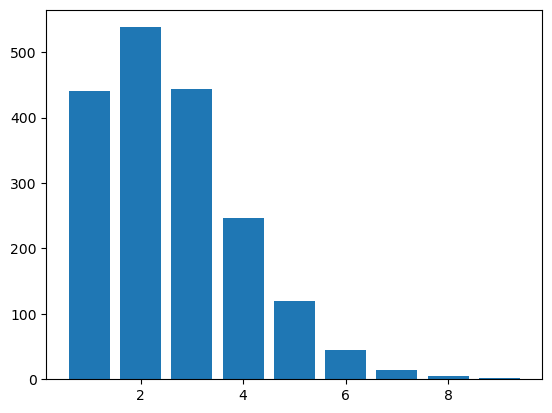

In [28]:
plt.bar(cnt_hc_1.keys(), cnt_hc_1.values())
plt.show()

In [29]:
cnt_hc_2= Counter(map(len, hash_conflicts_2.values()))
cnt_hc_2

Counter({22: 360,
         17: 246,
         25: 261,
         19: 319,
         21: 356,
         28: 123,
         24: 299,
         27: 168,
         30: 79,
         23: 297,
         26: 195,
         16: 178,
         12: 32,
         32: 35,
         29: 94,
         20: 325,
         13: 65,
         31: 50,
         35: 10,
         15: 132,
         18: 288,
         14: 102,
         33: 20,
         38: 1,
         36: 7,
         34: 16,
         11: 19,
         10: 11,
         39: 1,
         9: 5,
         8: 3,
         37: 1,
         7: 1})

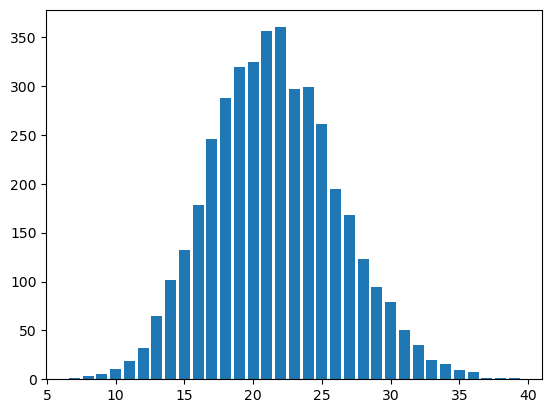

In [30]:
plt.bar(cnt_hc_2.keys(), cnt_hc_2.values())
plt.show()

In [31]:
cnt_hc_3 = Counter(map(len, hash_conflicts_3.values()))

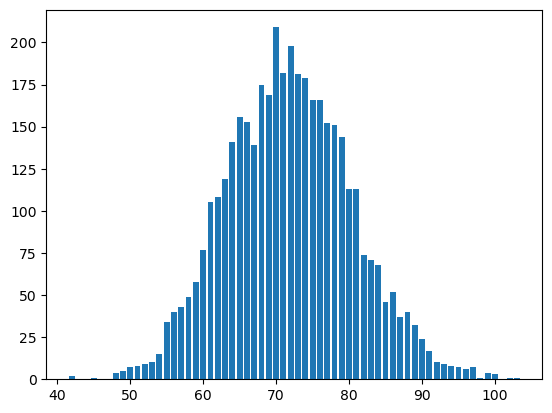

In [32]:
plt.bar(cnt_hc_3.keys(), cnt_hc_3.values())
plt.show()

## Multihot encoding

In [33]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

In [34]:
list(map(lambda x: hash(x) % MAX_TRIGRAMS, all_ngrams('banana')[2]))

[3978, 2186, 2132, 2186]

In [35]:
MAXES = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

In [36]:
def hash_ngrams(ngrams, modulos):
    hash_codes = []
    for ngram_l, modulo in zip(ngrams, modulos):
        hash_codes += [list(map(lambda x: hash(x) % modulo, ngram_l))]
    return hash_codes

In [37]:
hash_banana = hash_ngrams(all_ngrams('banana'), MAXES)
hash_banana

[[826, 714, 1677, 714, 1677, 714],
 [944, 2001, 3289, 2001, 3289],
 [3978, 2186, 2132, 2186]]

## Relative Frequencies
CLD3 associates the n-grams with their relative frequencies in the text

In [38]:
def rel_freqs(lst):
    return {ngram: lst.count(ngram)/len(lst) 
           for ngram in set(lst)}

In [39]:
list(map(rel_freqs, hash_banana))

[{714: 0.5, 826: 0.16666666666666666, 1677: 0.3333333333333333},
 {944: 0.2, 2001: 0.4, 3289: 0.4},
 {3978: 0.25, 2132: 0.25, 2186: 0.5}]

## Multihot vectors

In [40]:
def multihot(idxes, max):
    feat_vector = torch.zeros(max)
    for idx in idxes:
        feat_vector[idx] = 1.0
    return feat_vector

In [41]:
mhot_char_banana = multihot(hash_banana[0], MAX_CHARS)
mhot_char_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [42]:
for i in range(mhot_char_banana.size()[0]):
    if mhot_char_banana[i] == 1.0:
        print(i)

714
826
1677


In [43]:
multihot(hash_banana[1], MAX_BIGRAMS)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [44]:
multihot(hash_banana[2], MAX_TRIGRAMS)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

## Replacing Booleans with Frequencies

In [45]:
def freq_vectorizer(idx_freq, max):
    feat_vector = torch.zeros(max)
    for idx, freq in idx_freq.items():
        feat_vector[idx] = freq
    return feat_vector

In [46]:
freqs_banana = list(map(rel_freqs, hash_banana))
freqs_banana

[{714: 0.5, 826: 0.16666666666666666, 1677: 0.3333333333333333},
 {944: 0.2, 2001: 0.4, 3289: 0.4},
 {3978: 0.25, 2132: 0.25, 2186: 0.5}]

In [47]:
freq_char_banana = freq_vectorizer(freqs_banana[0], MAX_CHARS)
freq_char_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [48]:
for i in range(freq_char_banana.size()[0]):
    if freq_char_banana[i]:
        print(i, freq_char_banana[i])

714 tensor(0.5000)
826 tensor(0.1667)
1677 tensor(0.3333)
